# Exploratory Data Analysis of World Development Indicators

The development indicators in this notebook come from a collection of metrics on global development compiled by the World Bank. There are over one thousands fields in the dataset covering a wide range of economic, health, and demographic measurements. These measures are in part collected by the World Bank but mostly they come from United Nations agencies, academic studies and governental statistics agencies.

## Importing Data

The world development indicators are made publically available under the Creative Commons Attribution 4.0 licence by the World Bank via their Data Catalog. Version 15 of this dataset was accessed on Thursday 27 October 2022 and uploaded to a private PostgreSQL database.

In [1]:
import csv
from io import StringIO
import time
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [9]:
# Read the link to the postgres server from the project's notes folder
with open('../Notes/postgres_string.txt','r') as f:
    postgres_string = f.readline()
engine = create_engine(postgres_string, pool_pre_ping=True)
# SQL for querying an entire table
sql = 'SELECT * FROM "Data";'
# Return SQL query as a pandas dataframe
with engine.connect() as conn:
    # Set 1.5 minutes statement timeout (units are milliseconds)
    conn.execute("SET statement_timeout = 90000;")
    df = pd.read_sql(sql, conn)

SQL query result assigned to a Pandas dataframe (df).

In [10]:
# verify the size of imported dataset
df.shape

(383572, 67)

In [11]:
# inspect the contents
df.head()

Country Name Country Code  \
0  Africa Eastern and Southern          AFE   
1  Africa Eastern and Southern          AFE   
2  Africa Eastern and Southern          AFE   
3  Africa Eastern and Southern          AFE   
4  Africa Eastern and Southern          AFE   

                                      Indicator Name     Indicator Code  1960  \
0  Access to clean fuels and technologies for coo...     EG.CFT.ACCS.ZS   NaN   
1  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.RU.ZS   NaN   
2  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.UR.ZS   NaN   
3            Access to electricity (% of population)     EG.ELC.ACCS.ZS   NaN   
4  Access to electricity, rural (% of rural popul...  EG.ELC.ACCS.RU.ZS   NaN   

   1961  1962  1963  1964  1965  ...       2013       2014       2015  \
0   NaN   NaN   NaN   NaN   NaN  ...  16.936004  17.337896  17.687093   
1   NaN   NaN   NaN   NaN   NaN  ...   6.499471   6.680066   6.859110   
2   NaN   NaN   NaN   NaN   NaN  ...  37.855399  38.046781  38.326255   
3   NaN   NaN   NaN   NaN   NaN  ...  31.794160  32.001027  33.871910   
4   NaN   NaN   NaN   NaN   NaN  ...  18.663502  17.633986  16.464681   

        2016       2017       2018       2019       2020  2021  Unnamed: 66  
0  18.140971  18.491344  18.825520  19.272212  19.628009   NaN         None  
1   7.016238   7.180364   7.322294   7.517191   7.651598   NaN         None  
2  38.468426  38.670044  38.722783  38.927016  39.042839   NaN         None  
3  38.880173  40.261358  43.061877  44.270860  45.803485   NaN         None  
4  24.531436  25.345111  27.449908  29.641760  30.404935   NaN         None  

[5 rows x 67 columns]

## Cleaning Data

In [12]:
df.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       'Unnamed: 66'],
      dtype='object')

In [13]:
# verify is the 'Unnamed: 66' column is empty
len(df) - df['Unnamed: 66'].isna().sum()  # returns 0
# dropping the empty column
df.drop(columns=['Unnamed: 66'], inplace=True)

In [14]:
# inspect for aggregate groups (e.g. Euro area)
df['Country Name'].unique()

array(['Africa Eastern and Southern', 'Arab World',
       'Africa Western and Central', 'European Union', 'High income',
       'IBRD only', 'IDA only', 'IDA total', 'Middle income',
       'American Samoa', 'Andorra', 'Bahrain', 'Caribbean small states',
       'Central Europe and the Baltics', 'Early-demographic dividend',
       'East Asia & Pacific', 'Belgium', 'Brazil',
       'East Asia & Pacific (excluding high income)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)',
       'East Asia & Pacific (IDA & IBRD countries)',
       'Fragile and conflict affected situations',
       'Heavily indebted poor countries (HIPC)', 'IDA & IBRD total',
       'Europe & Central Asia (IDA & IBRD countries)', 'IDA blend',
       'Late-demographic dividend', 'Latin America & Caribbean',
       'Low income', 'Latin America & Caribbean (excluding high income)',
       'Lower middle income', 'Middle East & North Africa',
       'Latin America & th

The 'Country Name' column contains both country names and economic groups (e.g. Euro area), we need a way to extract only the country names from the column.

If we don't remove the economic groups from the dataset then we risk double counting in our analysis, for example, Germany will be present in all rows labeled Germany as well as in the aggregate statistics of all rows labeled Euro area.

Instead of using the 'Country Names' column, the 'Country Code' might be an easier way to eliminate the economic groups from the dataset, leaving only countries.

The country codes are based of the International Standards Organisation's (ISO) alpha-3 country codes standard, these can be quickly webscraped from Wikipedia.

### Webscraping ISO country codes

In [15]:
import requests
from bs4 import BeautifulSoup

# scrape the site and assign to the soup variable 
page = requests.get("https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3")
soup = BeautifulSoup(page.content, "html.parser")

In [16]:
# extract the list with the ISO codes
ISO_list = soup.find("div", {"class","plainlist"})
ISO_list = ISO_list.find_all('span')

In [17]:
# remove the remaining html script around the list items
ISO_list = [str(i).replace('<span class="monospaced">','') for i in ISO_list]
ISO_list = [str(i).replace('</span>','') for i in ISO_list]

Using the ISO country code list we can filter the dataset to remove all the economic groups (which are aggregates of the countries in the data), leaving the dataset with only countries and dependent territories, minimising the risk of double counting in the analysis.

In [18]:
# filter the dataset using country codes
df = df[df['Country Code'].isin(ISO_list)]

## Reshaping Data Tables

To reshape the data so that each row represents one development indicator in one territory for one calendar year the columns representing the calendar years need to be "unpivotted" into a single column.

In [19]:
# split cols based on id fields (i.e. country, indicator) and calendar years
id_fields = list(df.columns[:4]) # id fields
cal_years = list(df.columns[4:]) # calendar years

In [20]:
# "unpivot" the dataframe
df = pd.melt(df, id_vars=id_fields, value_vars=cal_years, var_name='Year', value_name='Value')

In [21]:
# Inspecting data types shows 'Year' has the incorrect type
df.dtypes 

Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
Year               object
Value             float64
dtype: object

In [22]:
# change the data type for 'Year' column
df['Year'] = pd.to_numeric(df['Year'], errors='ignore')

In [23]:
# not all territories have complete records dating back to 1960
df['Value'].isna().sum()

12721748

In this exploratory analysis missing values are still of interest, as they can provide us information about the completeness of the dataset, so we will keep them in the data.

In [24]:
df['Country Name'].nunique() * df['Indicator Name'].nunique() * df['Year'].nunique()

19221860

If we have a complete dataset of every development indicator for each country for each year (1960 - 2021) we would expect 19221860 rows, we can calculate this by computing the product of the unique variables in the 'Country Name', 'Indicator Name' and 'Year' fields.

In [25]:
len(df)

19221860

From the above measure of the length of the dataset we see that we do indeed have the expected number of rows in our dataset, but it is important to note that although we have the correct number of rows two thirds are missing values (66%).

In [26]:
# calaculate proportion of missing data
df['Value'].isna().sum() / len(df)

0.6618375120825977

In [27]:
# storing the cleaned reshaped data
df.to_csv('df_cleaned.csv') 

## Visualising Data Completeness

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()
sns.set_style('whitegrid')

In [31]:
df = pd.read_csv('../Data/df_cleaned.csv')

In [32]:
# using groupby to count the non-null values
df_grouped = df.groupby(by=['Indicator Name','Year'], dropna=True).count()['Value']

In [33]:
# create a 2D array of count of measures by year and measure name
df_array = df_grouped.unstack()

In [34]:
# sort the array by the indicators with the highest valid measure counts over time
df_array['total'] = df_array.sum(axis=1) # sums over time
df_array.sort_values(by='total', ascending=False, inplace=True)
df_array.drop('total', axis=1, inplace=True)

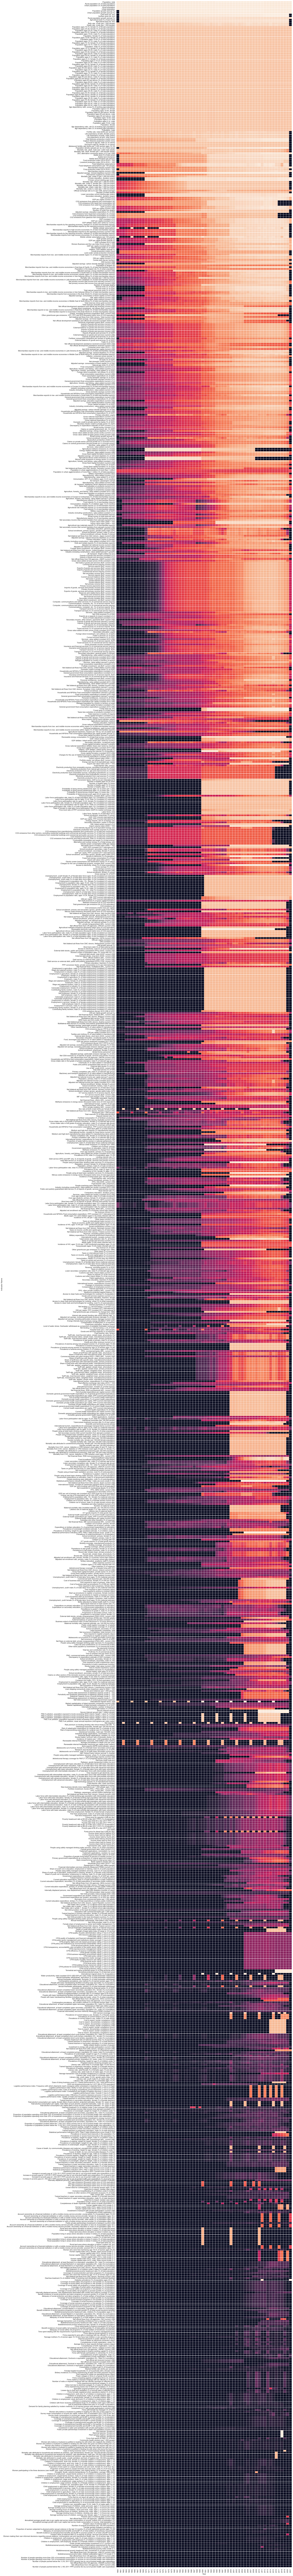

In [35]:
# plot a heatmap of indicators against year
fig, ax = plt.subplots(figsize=(20, 300))
sns.heatmap(df_array, ax=ax, linewidths=.1, cbar=False)
# plt.show()
plt.savefig('../Results/completeness heatmap')

The heatmap above shows the total number of countries with a value for a particular development indicator (y axis) plotted against the corresponding year that development indicator was recorded (x axis), the indicators at the top of the y axis are those with the highest completeness (i.e. most countries have a value for this indicator over time) and the indicators at the bottom of the y axis are those with the lowest completeness - this visualisation is best viewed on a large screen.

We can see that demographic data on populations tend to have the highest completeness, and data on child employment tend to feature heavily in the development indicators with the lowest completeness.

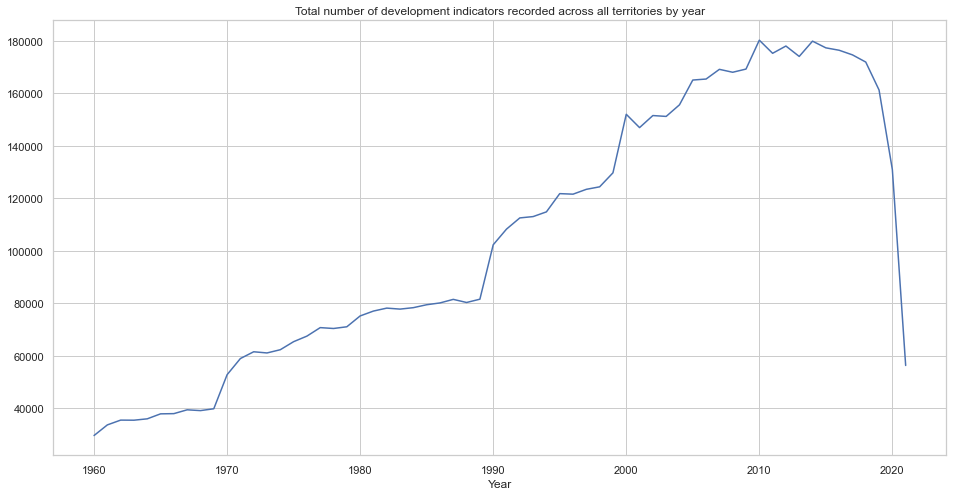

In [36]:
# plot total development indicators over time
df_grouped.groupby(by=['Year']).sum().plot(figsize=(16,8))
plt.title("Total number of development indicators recorded across all territories by year")
# plt.show()
plt.savefig('../Results/completeness over time')

The count of indicator datapoints over time has steadily increased from 1960 to 2010, at which point the trend plateaued and then went into a steep decline from 2018 onwards - this is possibly due to a reporting delay at the agencies the World Bank uses to collect development indicators.

## Key Insights

- 66% of development indicators values are missing for a given territory in a given year, although data completeness has steadily improved since records began in 1960 - data completeness peaks in 2010 and 2014.

- The most complete development indicators are those related to population statistics and the least complete are development indicators related to child employment.

- The period with the most complete development indicator values spans from 2010 to 2014, this could potentially be due to the data gathering efforts carried out by numerous government agencies in lead up to the establishment of the Sustainable Development Goals in 2015 by the United Nations General Assembly.